In [ ]:
#一些常用的命令
!nvidia-smi

import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')

In [ ]:
#一些常用的命令
!git status
!git add .
!git commit -m "correct and optimize some code"
!git push

In [ ]:
############print("程序0.000 全局共享函数，运行主程序前需要运行")


import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import  plot_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler

import pickle  


########################################################################################################################
#######开始为功能函数
print("全局共享函数，运行主程序前需要运行")
def dtFitAndSave(x,y,saveName):
    str1="dtFitAndSave,用于决策树拟合和识别"
    
    dt = tree.DecisionTreeClassifier(max_depth=7,min_samples_leaf=100)
    dt = dt.fit(x, y)
    tree.plot_tree(dt)
    #data=tree.export_graphviz(dt, out_file=None,class_names=None,filled=True) 
    #graph = graphviz.Source(data)
    #graph.render(saveName)
    
    yPredict = dt.predict(x)
    tmp1 = classification_report(y,yPredict)
    print("纯决策树的识别\n",tmp1)
    mat1num = confusion_matrix(y,yPredict)
    mat2acc = confusion_matrix(y,yPredict,normalize='pred')
    print(mat1num)
    print(np.around(mat2acc , decimals=3))
    #text_representation = tree.export_text(dt)
    #print(text_representation)
    #yPredict = dt.predict_proba(x)
    #index = np.where((yPredict[:,1]<0.98)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.90)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.80)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.70)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    return dt,yPredict

########################################################################################################################
###简单模型3，resnet_like
def local_model(num_labels, dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_labels, activation='sigmoid'))
    return model

def global_model(dropout_rate, relu_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(relu_size, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    return model



def sigmoid_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='sigmoid',name="global"))
    return model

def softmax_model(label_size):
    model = tf.keras.Sequential()
    model.add(layers.Dense(label_size, activation='softmax',name="global"))
    return model
'''
############################################################################
############################################################################
#单层模型
def kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName):
    str1="kerasFitAndSaveSimple3LikeResnet,用于resnet_like的神经网络拟合和识别"
    
    nSamples,features_size = x.shape
    relu_size = 512
    dropout_rate = 0.05
    hierarchy = [1,1,1,1]#四层，对于当前数据集已经足够了
    global_models = []
   
    
    label_size = num_labels
    features = layers.Input(shape=(features_size,))
    for i in range(len(hierarchy)):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))

   
    
    p_glob = sigmoid_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[features], outputs=[p_glob])
    #model = tf.keras.Model(inputs=[features], outputs=[build_model])
    #enc = OneHotEncoder()
    #enc.fit(y)  
    #yOnehot=enc.transform(y).toarray()
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='binary_crossentropy',metrics=['accuracy'])
    if 1:
       build_model = keras.models.load_model(saveName)
    if 1:#用于画图
        #build_model.fit([x],[yOneHot],epochs=1, batch_size=10000*1)
        build_model.fit(x,yOneHot,epochs=1, batch_size=10000*1)
        plot_model(build_model, to_file='KerasSimple3_likeResnet_4lay512nodes.jpg', show_shapes=True)
    
  
    build_model.fit(x,yOneHot,epochs=1500, batch_size=40000*1)#GPU用这个
    #saveName = "KerasSimple3_likeResnet.h5"
    build_model.save(saveName)
    plot_model(build_model, to_file='KerasSimple3_likeResnet_4lay512nodes.jpg', show_shapes=True)
    return build_model

############################################################################
############################################################################
####HMCM-F ,层次模型，发现hmcn-f训练效果很差，
def kerasFitAndSaveHierSimple4LikeResnet(x,yOneHot,num_labels,saveName):
    str1="kerasFitAndSaveHierSimple4LikeResnet,用于resnet_like的 神经网络拟合和识别"
    
    nSamples,features_size = x.shape
    relu_size = 256
    dropout_rate = 0.05
    beta = 0.5
    hierarchy = [2,4,6,8,9]#5层，对于当前数据集已经足够了
    global_models = []
    local_models = []
    
    label_size = num_labels
    features = layers.Input(shape=(features_size,))
    for i in range(len(hierarchy)):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))
    
    p_glob = sigmoid_model(label_size)(global_models[-1])
    
    for i in range(len(hierarchy)):
        local_models.append(local_model(hierarchy[i], dropout_rate, relu_size)(global_models[i]))
        
        
    #显示只有局部局模型的情况(部分全局)
    p_loc = layers.concatenate(local_models)
    #modelTmp2 = tf.keras.Model(inputs=[features], outputs=[p_loc])
    #modelTmp2.summary()#
    #plot_model(modelTmp2, to_file='Flatten2.png', show_shapes=True)
    p_glob1 = layers.Lambda(lambda x: x*beta,name="global")(p_glob)
    p_loc1 = layers.Lambda(lambda x: x*(1-beta),name="local")(p_loc)

    labels = layers.add([p_glob1, p_loc1])


    build_model = tf.keras.Model(inputs=[features], outputs=[labels])
    
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.01),loss='binary_crossentropy',metrics=['accuracy'])
    if 1:
        build_model = keras.models.load_model(saveName)
    if 1:#用于画图
        #build_model.fit([x],[yOneHot],epochs=1, batch_size=10000*1)
        build_model.summary()
        build_model.fit(x,yOneHot,epochs=1, batch_size=10000*1)
        plot_model(build_model, to_file='hmcnf1.jpg', show_shapes=True)
    
  
    build_model.fit(x,yOneHot,epochs=3500, batch_size=40000*1)#GPU用这个
    build_model.save(saveName)
    return build_model

'''
############################################################################
############################################################################
####HMCM-F ,层次模型，发现hmcn-f训练效果很差，所以采用分离式
###每一层的识别模型都是4层模型
def g_sepHier1(x,yOneHot,num_labels,saveName,levelIndex,numLayers,numEpochs = 10,srelu_size = 256,dropout_rate = 0.05):
    str1="layIndex-"+str(levelIndex)
    
    nSamples,features_size = x.shape
    relu_size = 256
    dropout_rate = 0.01
    global_models = []
    
    label_size = num_labels
    features = layers.Input(shape=(features_size,))
    for i in range(numLayers):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))
    
    p_glob = softmax_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[features], outputs=[p_glob])

    
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    if 0:
        build_model = keras.models.load_model(saveName)
    if 1:#用于画图
        #build_model.fit([x],[yOneHot],epochs=1, batch_size=10000*1)
        build_model.summary()
        build_model.fit(x,yOneHot,epochs=1, batch_size=10000*1)
        plot_model(build_model, to_file=str1+".jpg", show_shapes=True)
    
  
    build_model.fit(x,yOneHot,epochs=numEpochs,batch_size=40000*1)#GPU用这个
    build_model.save(saveName)
    return build_model

########################################################################################################################
########################################################################################################################
def getKerasResnetRVL(x,enc,saveName):
    model_name = saveName 
    model = keras.models.load_model(model_name)
    y= model.predict([x], batch_size=2560)
    nSamples = y.shape[0]
    ###需要将预测出的值，转换01整数,并转为数字式
    for i in range(y.shape[0]):
        tmp = y[i]
        index=  np.argmax(tmp)
        y[i] = [0]*y.shape[1]
        y[i,index]=1
   

    ###  
    y= enc.inverse_transform(y)
    y= y.reshape(-1,nSamples)[0]
    
    
    return y

def string2int(inputString):
     #print(inputString)
     tmp = 0
     try:
         strTmp=[str(ord(x)) for x in inputString]
         tmp=tmp.join(strTmp)
         tmp = float(tmp)/(len(inputString)*128)
     except:
         #print(inputString)
         strTmp = inputString
         tmp= "0"
         tmp = 0
     return tmp
 ## 根据经验以及最佳正确率的合并方法
 #第一次合并为0,1的合并

########################################################################################################################
##手工确定层次结构，以前测试时候为5层，根据论文为9层
def convertY2Hieral(y):
    #mat2acc
    # [[0.914 0.009 0.017 0.007 0.032 0.    0.    0.    0.   ]
    # [0.027 0.984 0.006 0.007 0.018 0.    0.    0.    0.   ]
    # [0.02  0.006 0.972 0.    0.011 0.    0.    0.    0.   ]
    # [0.036 0.002 0.    0.986 0.014 0.    0.002 0.    0.   ]
    # [0.003 0.    0.    0.    0.925 0.    0.    0.    0.   ]
    # [0.    0.    0.    0.    0.    1.    0.005 0.    0.   ]
    # [0.    0.    0.    0.    0.    0.    0.993 0.    0.004]
    # [0.    0.    0.    0.    0.    0.    0.    0.996 0.   ]
    # [0.    0.    0.004 0.    0.    0.    0.    0.004 0.996]]
    
    
    #hierarchy = [2,4,6,8,9]
   # labelDict = {"0":["01234","0123","012","01","0"],\
   #               "1":["01234","0123","012","01","1"],\
   #               "2":["01234","0123","012","2","2"],\
   #               "3":["01234","0123","3","3","3"],\
   #              "4":["01234","4",    "4","4","4"],\
   #              "5":["5678","5",     "5","5","5"],\
   #              "6":["5678","678",   "67","6","6"],\
   #              "7":["5678","678",   "67","7","7"],\
   #              "8":["5678","678",   "8","8","8"],\
   #               }
    
    hierarchy = [2,3,4,5,6,7,8,9]
    labelDict = {"0":["01234",        "01234",        "01234",   "01234",      "0123","012","01","0"],\
                  "1":["01234",        "01234",        "01234",  "01234",     "0123","012","01","1"],\
                  "2":["01234",          "01234",      "01234",  "01234",     "0123","012","2","2"],\
                  "3":["01234",         "01234",       "01234",  "01234",    "0123","3","3","3"],\
                 "4":["01234",          "01234",       "01234",  "01234" ,     "4", "4","4","4"],\
                 "5":["5678",               "5",        "5" ,      "5",       "5", "5","5","5"],\
                 "6":["5678",            "678",        "6",        "6",       "6", "6","6","6"],\
                 "7":["5678",             "678",       "78",       "7",       "7", "7","7","7"],\
                 "8":["5678",             "678",       "78" ,      "8",        "8", "8","8","8"],\
                  }
    '''
    hierarchy = [5,9]
    labelDict = {"0":["01","0"],\
                  "1":["01","1"],\
                  "2":["2","2"],\
                  "3":["34","3"],\
                "4":["34","4"],\
                 "5":["56","5"],\
                 "6":["56","6"],\
                 "7":["78","7"],\
                 "8":["78","8"],\
                 }
    '''

    y1 = [list(labelDict[str(x)]) for x in y]
   
    #print("!!!y1.type:", type(y1))
    #print(y1[:2])
    #y2 = [t1[0] for t1 in y1]
    #print(len(y2))
  

    return y1,hierarchy 



In [ ]:
##主程序开始######################################################################################################################
print("0.主程序开始，建立多层嵌套决策树模型，3080ti的GPU是AMD2400CPU 运算速度100倍")
print("0.这是简化程序，原始带有更多测试和原始模型的程序在mainTestCSVMLP3(hmcnf_keras).ipynb")
print("程序编号为0")
########################################################################################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import  plot_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler

import pickle  


############################################################################
####HMCM-F ,层次模型，发现hmcn-f训练效果很差，所以采用分离式
###每一层的识别模型都是4层模型
def sepHier1(x,yOneHot,num_labels,saveName,levelIndex,numLayers,numEpochs = 10,srelu_size = 256,dropout_rate = 0.05):
    
    str1="layIndex-"+str(levelIndex)
    
    nSamples,features_size = x.shape
    relu_size = 256
    dropout_rate = 0.05
    global_models = []
    
    label_size = num_labels
    featuresInput = layers.Input(shape=(features_size,))
    features = layers.BatchNormalization()(featuresInput)
    #features=featuresInput
    for i in range(numLayers):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))
    
    p_glob = softmax_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[featuresInput], outputs=[p_glob])

    
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    if 1:
        build_model = keras.models.load_model(saveName)
    if 1:#用于画图
        #build_model.fit([x],[yOneHot],epochs=1, batch_size=10000*1)
        #build_model.summary()
        build_model.fit(x,yOneHot,epochs=1, batch_size=10000*1)
        plot_model(build_model, to_file=str1+".jpg", show_shapes=True)
    
  
    build_model.fit(x,yOneHot,epochs=numEpochs,batch_size=160000*1)#GPU用这个
    build_model.save(saveName)
    return build_model






########################################################################################################################
########################################################################################################################
########################################################################################################################
print("0.主程序开始, 建立多层嵌套决策树模型,3080ti的GPU是AMD2400CPU 运算速度100倍")
np.random.seed(42)
tf.random.set_seed(42)

#from tensorflow.keras.mixed_precision import experimental as mixed_precision
#policy = mixed_precision.Policy('mixed_float16')
#mixed_precision.set_policy(policy)

 
########################################################################################################################    
########################################################################################################################
print("读取France数据并且把数据进行onehot处理")

#file1 = "../trainData/france_0_allSamples1.csv"
file1 = "../trainData/france_0_allSamples1_2slot.csv"
xyDataTmp = pd.read_csv(file1)
#print(xyDataTmp.info())
xyData = np.array(xyDataTmp)
h,w = xyData.shape
#x = xyData[:,1:23]#简单处理与SUMO数据库一致
x0rigin = xyData[:,1:w-1]#用所有的数据,第0列为vehID,不要
y0rigin  = xyData[:,w-1]

x0rigin[:,6] = [string2int(inputString) for inputString in x0rigin[:,6] ]#字符串vehLaneID 变为整数

x0rigin =x0rigin.astype(np.float32)#GPU 加这个
y0rigin =y0rigin.astype(np.int64)#GPU 加这个


ros = RandomOverSampler(random_state=0)
x0,y0= ros.fit_resample(x0rigin , y0rigin)#对数据不平衡进行处理，保证样本数一致

x0=x0.astype(np.float32)#GPU 加这个
y0=y0.astype(np.int64)#GPU 加这个
yl5 = y0
print("x0.shape:",x0.shape,"y0.shape:",y0.shape,"y0.type:", type(y0) )
del xyDataTmp #节省内存
del xyData #节省内存



    
########################################################################################################################    
########################################################################################################################
###现在暂时不训练多层模型，只训练9label模型
if 0:
    print("训练4层, 9 label 模型")
    x=x0
    y=yl5
    x=x.astype(np.float32)#GPU 加这个
    y=y.astype(np.int64)#GPU 加这个
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
    
    num_labels = 9 
    nSamples,nFeatures =  x.shape
    enc = OneHotEncoder()
    y= y.reshape(nSamples,-1)
    
    print("y.shape:",y .shape,"y.type:", type(y) )
    enc.fit(y)
    yOneHot=enc.transform(y).toarray()
    saveName = "../trainedModes/model-9label-4lays-512nodes-2slots-gpu1.h5"
    if 0:
        kerasModel3_5label = kerasFitAndSaveSimple3LikeResnet(x,yOneHot,num_labels,saveName)     
    yKeras_5label=getKerasResnetRVL(x,enc,saveName)
    
    print('keras\n')
    mat1num = confusion_matrix(y, yKeras_5label)
    mat2acc = confusion_matrix(y, yKeras_5label,normalize='pred')
    print('mat1num\n',mat1num)
    print('mat2acc\n',np.around(mat2acc , decimals=3))
    
    
########################################################################################################################    
########################################################################################################################   
########################################################################################################################    
########################################################################################################################    
print("##############################################################################################################")
print("\n\n\n")
print("1.接编号为0的主程序,根据基于正确率的聚类程序或者经验将底层类别归结到上一层的类别")
print("2.程序编号为0+")  
 
'''
if 0:# 训练统合样式的HMCN-F多级模型
    print("训练5hieral, 4层, 9 label 模型")
    x=x0
    y=yl5
    x=x.astype(np.float32)#GPU 加这个
    y=y.astype(np.int64)#GPU 加这个
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
    yH1 = convertY2Hieral(y)
    hierarchy = [2,4,6,8,9]#5层，对于当前数据集已经足够了
    
    yH1= np.array(yH1)
    
    nSamples,nFeatures =  x.shape
    enc = OneHotEncoder()
    yH1= yH1.reshape(nSamples,-1)
    #print(yH1[:3])
    print("yH1.shape:",yH1 .shape,"yH1.type:", type(yH1) )
    enc.fit(yH1)
    #print(enc.categories_,enc.get_feature_names())
    yOneHot=enc.transform(yH1).toarray()
    #print(yOneHot[:3])
    
    num_labels = yOneHot.shape[1] 
    print(num_labels)
    saveName = "../trainedModes/model-5hier-9label-5lays-128nodes-2slots-gpu1.h5"
    kerasModel4_5hier_9label = kerasFitAndSaveHierSimple4LikeResnet(x,yOneHot,num_labels,saveName)   
'''    
    
########################################################################################################################    
########################################################################################################################


from sklearn.model_selection import train_test_split

if 1:# 训练多级模型
    print("训练分离式多级模型")
    
    #准备字典，用于保存训练后的数据"
    xFloors=  dict()
    yFloors =  dict()
    xTestFloors =dict()
    yTestFloors = dict()
    modSaveNameFloors =dict()
    encLevels= dict()
    yKerasFloors = dict()
    x=x0
    y=yl5
    x=x.astype(np.float32)#GPU 加这个
    y=y.astype(np.int64)#GPU 加这个
    print("x.shape:",x .shape,"y.shape:",y .shape,"y.type:", type(y) )
    print(y)
    
    #hierarchy = [2,4,6,8,9]
    #hierarchy = [2,3,4,5,6,7,8,9]
    yH1,hierarchy = convertY2Hieral(y)
    
    
    x_train, x_test, y_train, y_test = train_test_split(x, yH1, test_size=0.5, random_state=0)
   
    nSamples,nFeatures =  x_train.shape
    
    
    numEpochs =30 #1500/60/60*5 = 2houer
    
    
    for i in range(len(hierarchy)):
        print("\n\n levelIndex",i,"nSamples,nFeatures",x_train.shape)
        levelIndex = i
        numLayers = 4
        enc = OneHotEncoder()
        nSamples,nFeatures =  x_train.shape
       
            
        yCurLayer1 = [t1[i] for t1 in y_train]
        
        yCurLayer1 = np.array(yCurLayer1)
        print("yCurLayer1.shape:",yCurLayer1.shape)
        
        yCurLayer1= yCurLayer1.reshape(nSamples,-1)
        enc.fit(yCurLayer1)
        
        yOneHot=enc.transform(yCurLayer1).toarray()
        print(enc.categories_,enc.get_feature_names())
        print(yOneHot[:1])
        
        
        num_labels = hierarchy[i] 
        print("num_labels:", num_labels)
        saveName = "../trainedModes/modelSep-9level%d-%dlayer-2slots-gpu1.h5" %(i,numLayers)
        #saveName = "../trainedModes/modelSep-2level%d-%dlayer-2slots-gpu1.h5" %(i,numLayers)#基于拥堵定义的2层结构
        print(saveName)
        sepHier1(x_train,yOneHot,num_labels,saveName,levelIndex,numLayers,numEpochs)
        
        encLevels[str(i)] = enc
        xFloors[str(i)] = x_train
        yFloors[str(i)] = yCurLayer1
        
        
        nSamplesTest,nFeaturesT =  x_test.shape
        yCurLayerTest = [t1[i] for t1 in y_test]
        yCurLayerTest = np.array(yCurLayerTest)
        yCurLayerTest= yCurLayerTest.reshape(nSamplesTest,-1)
        
        xTestFloors[str(i)] = x_test
        yTestFloors[str(i)] = yCurLayerTest
        modSaveNameFloors[str(i)] = saveName
        
    #######保存为pickle文件,用于后期的SUMO和数据分析

    fpk=open('samples1.pkf','wb+')  
    pickle.dump([xFloors,yFloors,modSaveNameFloors,encLevels,xTestFloors, yTestFloors],fpk)  
    fpk.close() 

########################################################################################################################    
########################################################################################################################
#####用现有训练模型进行预测

fpk=open('samples1.pkf','rb')   
[xFloors,yFloors,modSaveNameFloors,encLevels,xTestFloors, yTestFloors]=pickle.load(fpk)  
fpk.close()  


yKerasFloors = dict()

for i in range(len(hierarchy)):
        levelIndex = i
        #x = xFloors[str(i)]
        #yCurLayer1 =  yFloors[str(i)]
        
        x = xTestFloors[str(i)]
        yCurLayer1 =  yTestFloors[str(i)]
        
        saveName =  modSaveNameFloors[str(i)] 
        enc = encLevels[str(i)]
        yOneHot=enc.transform(yCurLayer1).toarray()
        yPredict=getKerasResnetRVL(x,enc,saveName)
        print("分离式多层识别结果:第%d层\n" %i)
        mat1num = confusion_matrix(yCurLayer1,yPredict)
        print(mat1num)
        mat2acc = confusion_matrix(yCurLayer1,yPredict,normalize='pred')  
        print(np.around(mat2acc , decimals=3))
        yKerasFloors[str(i)] =  yPredict
        
        df = pd.DataFrame(np.around(mat2acc , decimals=3))
        fs = "test_mat2acc%d.csv" %i
        df.to_csv(fs,index= False, header= False)
        
fpk=open('samples2.pkf','wb+')  
pickle.dump([xFloors,yFloors,modSaveNameFloors,encLevels,yKerasFloors,xTestFloors,yTestFloors],fpk)  
fpk.close() 

 
      


In [ ]:

########################################################################################################################
print("1.接编号为0的主程序,先找出低概率样本，")
print("2.对较低概率的样本进行蒙特卡洛模拟分析，原始对应程序为mainSimSumoFranceDatra")
print("3.最终进行分析，程序编号为1")
print("3.最终进行分析，程序编号为1")
########################################################################################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree
#import graphviz 
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler
import pickle

import warnings
warnings.filterwarnings("ignore")
      


    
########################################################################################################################
print("1.1 主程序开始")
########################################################################################################################

########################################################################################################################
#####用现有训练模型进行预测

fpk=open('samples2.pkf','rb')   
[xFloors,yFloors,modSaveNameFloors,encLevels,yKerasFloors,xTestFloors,yTestFloors]=pickle.load(fpk)  
fpk.close()  

hierarchy=[2,3,4,5,6,7,8,9]
for i in [7]:
#for i in range(len(hierarchy)):
        levelIndex = i 
        x = xTestFloors[str(i)]
        yCurLayer1 =  yTestFloors[str(i)]
        #yP = yKerasFloors[str(i)]
        
        modeSaveName = "../trainedModes/modelSep-9level7-4layer-2slots-gpu1.h5"
        model = keras.models.load_model(modeSaveName)
        yPredictOut= model.predict([x], batch_size=2560)
        yPredictOut = np.around(yPredictOut , decimals=3)
        #print(yPredictOut)
        ymax1=np.max(yPredictOut,axis=1)
        ymax2=np.argmax(yPredictOut,axis=1)
        
        index = np.where(ymax1<0.5)[0]#提取最大值小于0.95的例子
        
        ylowpraPredictNN=yPredictOut[index]#对较低概率的样本
        xlowpra=x[index]
        ylowpraLabel = yCurLayer1[index]
        ylowPredictLabel = ymax2[index].reshape(-1,1)
        
        
        print("xlowpra.shape",xlowpra.shape)
        
        
        fpk=open('lowprobSamples.pkf','wb+')  
        pickle.dump([xlowpra,ylowpraLabel,ylowPredictLabel,ylowpraPredictNN],fpk)  
        fpk.close() 
        
        df = pd.DataFrame(xlowpra)
        fs = "lowprobSamplesX.csv"
        df.to_csv(fs,index= False, header= False)
       
        ylowPredictLabel = ymax2[index].reshape(-1,1)
        
        df = pd.DataFrame(np.concatenate([ylowpraLabel,ylowPredictLabel,ylowpraPredictNN],axis=1))
        fs = "lowprobSamplesY.csv"
        df.to_csv(fs,index= False, header=['ylowpraLabel','ylowPredictLabel','0','1','2','3','4','5','6','7','8'])
        
       





In [ ]:
########################################################################################################################
print("接程序1: 对较低概率的样本进行蒙特卡洛模拟分析,原始对应程序为mainSimSumoFranceDatra")
print("因为配置失误，采用将低概率的样本进行保存为文件，然后再root用户下命令行模式用SUMO模拟（不使用conda）")
print("输出为sumoSimData？？？.csv,里面有每个样本的sumo输出，kerasNN输出以及原始的输入输出")
print("程序编号为2")
print("程序编号为2")
########################################################################################################################
!python3 sumoSimByFrance.py#运行runSumoSimFun.py 中test3

接程序2: 综合SUMO输出，对keras输出进行优化。程序输入为程序2的输出
优化选择1.NN。 2 回归分析。3 概率分析。
程序编号为3
##############################################################################################################
程序编号为3.1，主程序开始运行
(10591, 16)
Index(['sampleIndex', 'outputAvgSpeed', 'originOutput', 'sumoOutputSpeedTag',
       'kerasPredictLabel', 'NN0', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'NN6',
       'NN7', 'NN8', 'smv1', 'smv2'],
      dtype='object')
(10591, 11)
(10591, 1)
#############################
数据预处理

#############################
原生keras

              precision    recall  f1-score   support

           0       1.00      0.17      0.30      3029
           1       0.30      0.21      0.24      2437
           2       0.00      0.00      0.00       298
           3       0.44      0.60      0.51      2752
           4       0.37      0.81      0.51      2075
           5       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0

    accuracy                           0

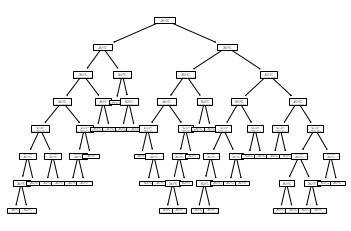

In [265]:
########################################################################################################################
print("接程序2: 综合SUMO输出，对keras输出进行优化。程序输入为程序2的输出")
print("优化选择1.NN。 2 回归分析。3 概率分析。")
print("程序编号为3")
########################################################################################################################
import tensorflow as tf
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.utils import  plot_model

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn import tree

import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from tensorflow import keras
import copy
from imblearn.over_sampling import RandomOverSampler

import pickle 
import sys
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import naive_bayes

from sklearn.metrics import accuracy_score
############################################################################
############################################################################
####建立NN模型，与sepHier2一样
def sepHier2(x,yOneHot,num_labels,saveName,levelIndex,numLayers,numEpochs = 10,srelu_size = 256,dropout_rate = 0.05):
    
    str1="layIndex-"+str(levelIndex)
    
    nSamples,features_size = x.shape
    relu_size = 256
    dropout_rate = 0.05
    global_models = []
    
    label_size = num_labels
    featuresInput = layers.Input(shape=(features_size,))
    features = layers.BatchNormalization()(featuresInput)
    #features=featuresInput
    for i in range(numLayers):
        if i == 0:
            global_models.append(global_model(dropout_rate, relu_size)(features))
        else:
            global_models.append(global_model(dropout_rate, relu_size)(layers.concatenate([global_models[i-1], features])))
    
    p_glob = softmax_model(label_size)(global_models[-1])
    build_model = tf.keras.Model(inputs=[featuresInput], outputs=[p_glob])

    
    build_model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
    if 1:
        build_model = keras.models.load_model(saveName)
    if 1:#用于画图
        #build_model.fit([x],[yOneHot],epochs=1, batch_size=10000*1)
        #build_model.summary()
        build_model.fit(x,yOneHot,epochs=1, batch_size=10000*1)
        plot_model(build_model, to_file=str1+".jpg", show_shapes=True)
    
  
    build_model.fit(x,yOneHot,epochs=numEpochs,batch_size=20000*1)#GPU用这个
    build_model.save(saveName)
    return build_model


def dtFit(x,y):
    str1="dtFitAndSave,用于决策树拟合和识别"
    
    dt = tree.DecisionTreeClassifier(max_depth=7,min_samples_leaf=100)
    dt = dt.fit(x, y)
    tree.plot_tree(dt)
    #data=tree.export_graphviz(dt, out_file=None,class_names=None,filled=True) 
    #graph = graphviz.Source(data)
    #graph.render(saveName)
    
    yPredict = dt.predict(x)
    tmp1 = classification_report(y,yPredict)
    print("纯决策树的识别\n",tmp1)
    mat1num = confusion_matrix(y,yPredict)
    mat2acc = confusion_matrix(y,yPredict,normalize='pred')
    print(mat1num)
    print(np.around(mat2acc , decimals=3))
    #text_representation = tree.export_text(dt)
    #print(text_representation)
    #yPredict = dt.predict_proba(x)
    #index = np.where((yPredict[:,1]<0.98)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.90)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.80)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    #index = np.where((yPredict[:,1]<0.70)&(yPredict[:,1]>0.5))
    #print(index[0].shape,index)
    return dt,yPredict
########################################################################################################################   
########################################################################################################################    
print("##############################################################################################################")

print("程序编号为3.1，主程序开始运行")

   

df = pd.read_csv('sumoSimData.csv', sep=',')

print(df.shape)
print(df.columns)
numSamples,numFeatures = df.shape

##['sampleIndex','outputAvgSpeed','originOutput','sumoOutputSpeedTag','kerasPredictLabel','smv1','smv2',\
 ##                                              'NN0','NN1','NN2','NN3','NN4','NN5','NN6','NN7','NN8'])
sumoOutput='sumoOutputSpeedTag'
yKerasOutput='kerasPredictLabel'
originOutput ='originOutput'
sumoOutList = ['smv1','smv2']
outputListNN = ['NN0','NN1','NN2','NN3','NN4','NN5','NN6','NN7','NN8']

df1 = df[sumoOutput]
x1 = df1.iloc[0:numSamples].to_numpy().reshape(-1,1)


df1 = df[yKerasOutput]
x2 = df1.iloc[0:numSamples].to_numpy().reshape(-1,1)

df1 = df[outputListNN]
x3 = df1.iloc[0:numSamples].to_numpy()


df1 = df[originOutput]
y = df1.iloc[0:numSamples].to_numpy().reshape(-1,1)
enc = OneHotEncoder()
enc.fit(y)
yOneHot=enc.transform(y).toarray()

x = np.concatenate([x1,x2,x3],axis=1)

print(x.shape)
print(y.shape)
#print(y)




print("#############################\n数据预处理\n")
#数据预处理
x_train, x_test, y_train, y_test = train_test_split(x, yOneHot, test_size=0.5, random_state=0)
   

rN,cN= np.where(np.isnan(x))
#print(rN,cN)
#print(rN.shape)

for i in range(rN.shape[0]):
    x[rN[i],cN[i]] = 0
 

print("#############################\n原生keras\n")
yPredict = x2
tmp1 = classification_report(y,yPredict)
mat1num = confusion_matrix(y,yPredict)
mat2acc = confusion_matrix(y,yPredict,normalize='pred')
print(tmp1)
print(mat1num)
print(np.around(mat2acc , decimals=3))


score = accuracy_score(yPredict, y)
print(score) 

print("#############################\n决策树\n")
dtFit(x,y)
   
print("#############################\n逻辑回归\n")    
model = LogisticRegression()
model.fit(x,y)
yPredict = model.predict(x)

tmp1 = classification_report(y,yPredict)
mat1num = confusion_matrix(y,yPredict)
mat2acc = confusion_matrix(y,yPredict,normalize='pred')
print(tmp1)
print(mat1num)
print(np.around(mat2acc , decimals=3))

score = accuracy_score(yPredict, y)
print(score) 
print("#############################\n贝叶斯高斯回归\n")
nb_cls = naive_bayes.GaussianNB().fit(x,y)
yPredict = nb_cls.predict(x) 

tmp1 = classification_report(y,yPredict)
mat1num = confusion_matrix(y,yPredict)
mat2acc = confusion_matrix(y,yPredict,normalize='pred')
print(tmp1)
print(mat1num)
print(np.around(mat2acc , decimals=3))

score = accuracy_score(yPredict, y)
print(score) 
print("#############################\nkerasNN\n")
print(x.shape)
print(yOneHot.shape)
num_labels = yOneHot.shape[1]
numLayers = 4
numEpochs = 5
saveName ="../trainedModes/stage2_1.h5";
levelIndex = 7

sepHier2(x,yOneHot,num_labels,saveName,levelIndex,numLayers,numEpochs)




fpk=open('samples2-stage2.pkf','wb')  
pickle.dump([df,x,y,yOneHot,x_train, x_test, y_train, y_test,enc,saveName],fpk)  
fpk.close() 



########################################################################################################################   

    
    


In [ ]:
########################################################################################################################   
########################################################################################################################   
import scipy.interpolate as si
from sklearn.metrics import accuracy_score

print("##############################################################################################################")

print("程序编号为3.2，手动权值分配")

df = pd.read_csv('sumoSimData.csv', sep=',')

print(df.shape)
print(df.columns)
numSamples,numFeatures = df.shape

##['sampleIndex','outputAvgSpeed','originOutput','sumoOutputSpeedTag','kerasPredictLabel','smv1','smv2',\
 ##                                              'NN0','NN1','NN2','NN3','NN4','NN5','NN6','NN7','NN8'])
sumoOutput='sumoOutputSpeedTag'
yKerasOutput='kerasPredictLabel'
originOutput ='originOutput'
sumoOutList = ['smv1','smv2']
outputListNN = ['NN0','NN1','NN2','NN3','NN4','NN5','NN6','NN7','NN8']



df1 = df[originOutput]
yo = df1.iloc[0:numSamples].to_numpy().reshape(-1,1)


df1 = df[sumoOutput]
x1 = df1.iloc[0:numSamples].to_numpy().reshape(-1,1)


df1 = df[yKerasOutput]
x2 = df1.iloc[0:numSamples].to_numpy().reshape(-1,1)

df1 = df[outputListNN]
x3 = df1.iloc[0:numSamples].to_numpy()

x = np.concatenate([x1,x2,x3],axis=1)
print(x)

manualOut = np.zeros((x3.shape[0],1))


#for i in range(10):
for i in range(x3.shape[0]):
    #print(i)
    nn1 = x3[i]
    sumoOut = x1[i][0]
    kerasOut = x2[i][0]
    originOut = yo[i][0]

    xIntp=[0,sumoOut,min(8,sumoOut+1),min(8,sumoOut+2),min(8,sumoOut+3),9]
    yIntp =[0,1,0.5,0.4,0.3,0]
    
    xIntp=[-9,sumoOut-1,sumoOut,sumoOut+1,9]
    yIntp =[0.5,0.7,1,0.7,0.5]
    f = si.interp1d(xIntp,  yIntp,kind=1)
    xi = [0,1,2,3,4,5,6,7,8]
    p= f(xi)
    yTmp = np.multiply(p,nn1)
    finalIndex = np.argmax(yTmp)
    manualOut[i] = finalIndex
    
    #print('sumoOut','kerasOut','originOut','finalIndex')
    #print(sumoOut,kerasOut,originOut,finalIndex)
    #print("nn1:",nn1)
    #print("p  :",np.round(p,decimals=3))
    #print("y3 :",np.round(y3,decimals=3))

  

print(yo.shape)
print(manualOut.shape)
tmp1 = classification_report(yo,manualOut)
mat1num = confusion_matrix(yo,manualOut)
mat2acc = confusion_matrix(yo,manualOut,normalize='pred')
print(tmp1)
print(mat1num)
print(np.around(mat2acc , decimals=3))

score = accuracy_score(manualOut, yo)
print(score) 

print("#############################\n原生keras\n")
yPredict = x2
tmp1 = classification_report(yo,yPredict)
mat1num = confusion_matrix(yo,yPredict)
mat2acc = confusion_matrix(yo,yPredict,normalize='pred')
print(tmp1)
print(mat1num)
print(np.around(mat2acc , decimals=3))

score = accuracy_score(yPredict, y)
print(score) 


print("############################################https://www.jb51.net/article/269941.htm")
#https://blog.csdn.net/ljyljyok/article/details/100552618
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

def objective(x,*args):
    x1,x2,x3,yo = args
    manualOut = np.zeros((x3.shape[0],1))
    for i in range(x3.shape[0]):
        #print(i)
        nn1 = x3[i]
        sumoOut = x1[i][0]
        kerasOut = x2[i][0]
        originOut = yo[i][0]

        

        xIntp=[-9,sumoOut-x[0],sumoOut,sumoOut+x[1],9]
        yIntp =[0.5,x[2],1,x[2],0.5]
        f = si.interp1d(xIntp,  yIntp,kind=1)
        xi = [0,1,2,3,4,5,6,7,8]
        p= f(xi)
        yTmp = np.multiply(p,nn1)
        finalIndex = np.argmax(yTmp)
        manualOut[i] = finalIndex

    score = accuracy_score(manualOut, yo)
    
    return -score



#args1 = (x1,x2,x3,yo)
#x0 = [1,1,0.3]
bounds1 = ((0, 4), (0, 4),(0.01, 0.9))

#constraints = {'type': 'ineq', 'fun': cons}

#res = minimize(objective, x0, args=args1,method='SLSQP',bounds=bounds1)
#print(res.fun)
#print(res.success)
#print(res.x)
#https://vimsky.com/zh-tw/examples/usage/python-scipy.optimize.dual_annealing.html
args1 = (x1,x2,x3,yo)
x0 = [1,1,0.3]
bounds1 = [[0, 4], [0, 4],[0.01, 0.9]]
res = dual_annealing(objective,bounds1,x0=x0, args=args1)
print(res.fun)
print(res.success)
print(res.x)

##############################################################################################################
程序编号为3.2，手动权值分配
(10591, 16)
Index(['sampleIndex', 'outputAvgSpeed', 'originOutput', 'sumoOutputSpeedTag',
       'kerasPredictLabel', 'NN0', 'NN1', 'NN2', 'NN3', 'NN4', 'NN5', 'NN6',
       'NN7', 'NN8', 'smv1', 'smv2'],
      dtype='object')
[[0.    4.    0.14  ... 0.    0.    0.   ]
 [0.    4.    0.178 ... 0.    0.    0.   ]
 [0.    4.    0.185 ... 0.    0.    0.   ]
 ...
 [0.    1.    0.184 ... 0.    0.    0.   ]
 [0.    1.    0.184 ... 0.    0.    0.   ]
 [0.    3.    0.342 ... 0.    0.    0.   ]]
(10591, 1)
(10591, 1)
              precision    recall  f1-score   support

           0       0.50      0.57      0.53      3029
           1       0.26      0.12      0.16      2437
           2       0.00      0.00      0.00       298
           3       0.51      0.35      0.42      2752
           4       0.42      0.81      0.55      2075

    accuracy                      

In [ ]:
########################################################################################################################
print("辅助程序 对模拟后的数据进行分析，计算正确率")
########################################################################################################################

import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report    
import numpy as np
import matplotlib.pyplot as plt
print("对于低概率样本的识别结果，采用keras和MCS的识别结果对比")
file1 = "./data-Copy1.csv"
xyDataTmp = pd.read_csv(file1,index_col=0)

print(xyDataTmp.head(3))
print(xyDataTmp.info())

file1 = "。./trainData/france_0_allSamples1.csv"
xyOrigin = pd.read_csv(file1,index_col=0)

originlabel =  xyDataTmp.iloc[:,1].to_numpy()
keraslabel =   xyDataTmp.iloc[:,2].to_numpy()      
mcslabel =     xyDataTmp.iloc[:,3].to_numpy()

#
    
print('\norigin_mcs')
mat1num = confusion_matrix(originlabel, mcslabel)
mat2acc = confusion_matrix(originlabel, mcslabel,normalize='pred')
print('mat1num\n',mat1num)
print('mat2acc\n',np.around(mat2acc , decimals=3))
      
print('\nmcs_keras')
mat1num = confusion_matrix(mcslabel, keraslabel)
mat2acc = confusion_matrix(mcslabel, keraslabel,normalize='pred')
print('mat1num\n',mat1num)
print('mat2acc\n',np.around(mat2acc , decimals=3))

print('\norgin_keras')
mat1num = confusion_matrix(originlabel, keraslabel)
mat2acc = confusion_matrix(originlabel ,keraslabel,normalize='pred')
print('mat1num\n',mat1num)
print('mat2acc\n',np.around(mat2acc , decimals=3))      

##用于分析实际标记类别大于预测标记类别
def analyzing1(tmp, xyDataTmp,xyOrigin): 
    dfTmp1 = xyDataTmp[tmp]
    #print(dfTmp1.head(5))
    
    
    
    df2 =  xyOrigin.iloc[dfTmp1.originIndex,:]   
    plt.show()
    df2["vehLaneID"].hist(figsize=(15, 4))
    #print(df2.info())
    print("df2 origin Shape:",df2.shape)
    
    df2.to_csv("tmpForAnalyzing.csv")
    
    tmp1 = df2['redLightTime'] - df2['arriveTime2'] >1.5 #红灯时间大于到达时间
    df3 = df2[tmp1]
    print("df3 = df2[df2['redLightTime'] - df2['arriveTime2'] >1.5] #红灯时间大于到达时间 ,df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing3.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))   
    
   
    tmp1 = df2['speed'] < 5/3.6 #本身速度就小于5/3.6
    df3 = df2[tmp1]
    print("df2['speed'] > 5/3.6 #本身速度就小于5/3.6,df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))   
    df3.to_csv("tmpForAnalyzing4.csv")
    
    tmp1 = df2['redLightTime'] - df2['arriveTime2'] >1.5  #红灯时间大于到达时间
    tmp1 = tmp1 | (df2['speed'] < 5/3.6) #本身速度就小于5/3.6
    df3 = df2[tmp1]
    print("红灯时间大于到达时间  or 本身速度就小于5/3.6,df3 shape:",df3.shape,"占输入样本比例为:",df3.shape[0]/df2.shape[0])
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))   
    df3.to_csv("tmpForAnalyzing5.csv")
    
    
    tmp1 = df2['arriveTime2'] - df2['redLightTime'] >0 #到达时间大于红灯时间
    tmp1 = tmp1 & (df2['speed'] > 5/3.6) #本身速度就大于于5/3.6
    tmp1 = tmp1 & (df2['vehPos_2'] > 0) #
    tmp1 = tmp1 & (df2['vehSpeed_2'] < 5/3.6) #
    tmp1 = tmp1 & (df2['vehPos_3'] >0) #
    tmp1 = tmp1 & (df2['vehSpeed_3'] <5/3.6) #
    
    df3 = df2[tmp1]
    print("到达时间大于红灯时间  and 本身速度就大于5/3.6,df3 shape:",df3.shape,"占输入样本比例为:",df3.shape[0]/df2.shape[0])
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))   
    df3.to_csv("tmpForAnalyzing6.csv")

def extractStillVeh2(df):
    df=df.rename(columns={'ArrTimeDivRedTime':'numStillVeh'})
    df=df.rename(columns={'lanAvgSpeed':'predictStats'})
    df['numStillVeh'] = 0
    df['predictStats'] = "unknown"
    for i in range(df.shape[0]):
        numStillVeh = 0
        tmp = df.iloc[i]
        redTime = tmp.iloc[0]
        vPosObj = tmp.iloc[1]
        predictStats = -1

        for j in range(20):
           
            vehPos = tmp.iloc[2*j+8]
            vehVeh = tmp.iloc[2*j+1+8]
            
            if vehPos >0 and vehVeh<5/3.6:#经验数据,参数
                numStillVeh = numStillVeh + 1
            elif vehPos >0 and  vPosObj > vehPos:
                timeTmp1 =(vehPos-j*6.5)/(vehVeh+0.001)#经验公式，到固定位置后，启动需要的时间
                if timeTmp1  < redTime +numStillVeh*1.5:
                    numStillVeh = numStillVeh + 1

            if vehPos >0 and vPosObj == vehPos and vehVeh<5/3.6:
                predictStats = "stop"#目标车要听停止
               

            if vehPos >0 and vPosObj == vehPos and vehVeh>5/3.6 :    
                timeTmp1 =(vehPos-j*6.5)/(vehVeh+0.001)#经验公式，到固定位置后需要的时间
                if timeTmp1  <= redTime +numStillVeh*1.5+1.5:#小于虚拟红灯结束时间
                     predictStats = "stop" #目标车要听停止
                else:        
                     predictStats = "no stop"  #目标车要不要停止
                
     
        df['numStillVeh'][i] = numStillVeh
        df['predictStats'][i] = predictStats

    return df
##用于分析实际标记类别小于预测标记类别， xyDataTmp["predicted Labels By MCS"] - xyDataTmp["origin speedFlag"]>0
def analyzing2(tmp, xyDataTmp,xyOrigin): 
    dfTmp1 = xyDataTmp[tmp]
    #print(dfTmp1.head(5))
    
    
    #1
    df2 =  xyOrigin.iloc[dfTmp1.originIndex,:]   
    plt.show()
    df2["vehLaneID"].hist(figsize=(15, 4))
    #print(df2.info())
    print("df2 origin Shape:",df2.shape)
    df2 = extractStillVeh2( df2)
    df2.to_csv("tmpForAnalyzing.csv")
    
    
    ######################################
    tmp1 = (df2['speedFlag'] == 0)  & (df2['predictStats'] == "stop") #红灯时间大于到达时间，这个结果难以理解
    
    df3 = df2[tmp1]
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))
    df3.to_csv("tmpForAnalyzing1.csv")
    
    tmp1 = (df2['speedFlag'] > 0)  & (df2['predictStats'] == "no stop") #红灯时间大于到达时间，这个结果难以理解
    df3 = df2[tmp1]
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))
    df3.to_csv("tmpForAnalyzing2.csv")
    
    
    tmp1 = (df2['speedFlag'] == 0)  & (df2['predictStats'] == "no stop") #红灯时间大于到达时间，这个结果难以理解
    df3 = df2[tmp1]
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))
    df3.to_csv("tmpForAnalyzing3.csv")
    
    tmp1 = (df2['speedFlag'] > 0)  & (df2['predictStats'] == "stop") #红灯时间大于到达时间，这个结果难以理解
    df3 = df2[tmp1]
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))
    df3.to_csv("tmpForAnalyzing4.csv")
    return
    
    '''
    #2
    tmp1 = df2['redLightTime'] - df2['arriveTime2'] >0 #红灯时间大于到达时间，这个结果难以理解
    df3 = df2[tmp1]
    print("df3 = df2[df2['redLightTime'] - df2['arriveTime2'] >0] #红灯时间大于到达时间 ,df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing2.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))   
    
    #3
    tmp1 =df2['arriveTime2'] - df2['redLightTime'] >3 #红灯时间小于到达时间3，
    tmp1 = tmp1 & (df2['speedFlag'] == 0) 
    
    df3 = df2[tmp1]
    print("#红灯时间小于于到达时间 ,df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing3.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))  
    
   
    #4据静止汽车数目，分析在df2['speedFlag'] > 0情况下，虚拟红灯时间小于于到达时间情况，也就是目标车可能不需要停下来
    
    tmp1 =(df2['speedFlag'] == 0) 
    tmp11 = df2['numStillVeh']*1.5+df2['redLightTime']
    #print(tmp11)
    #print(df2['arriveTime2'])
    tmp11 = tmp11 < df2['arriveTime2']
    #print(tmp11)
    tmp1 = tmp1 & tmp11  
    
    df3 = df2[tmp1]
    print("df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing4.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))  
    
    #5 据静止汽车数目，分析在df2['speedFlag'] > 0情况下，虚拟红灯时间大于到达时间情况，也就是目标车可能需要停下来
    tmp1 =(df2['speedFlag'] > 0) 
    tmp11 = df2['numStillVeh']*1.5+df2['redLightTime']
    #print(tmp11)
    #print(df2['arriveTime2'])
    tmp11 = tmp11 >= df2['arriveTime2']
    #print(tmp11)
    tmp1 = tmp1 & tmp11  
    
    df3 = df2[tmp1]
    print("df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing5.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))  
    
    
    #6 据静止汽车数目，分析虚拟红灯时间大于到达时间情况，也就是目标车可能需要停下来
  
    tmp11 = df2['numStillVeh']*1.5+df2['redLightTime']
    #print(tmp11)
    #print(df2['arriveTime2'])
    tmp11 = tmp11 >= df2['arriveTime2']
    #print(tmp11)
    tmp1 =  tmp11  
    
    df3 = df2[tmp1]
    print("df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing6.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4))
    
    
    #7 根据静止汽车数目，分析虚拟红灯时间小于到达时间情况，也就是目标车可能不需要停下来
    tmp11 = df2['numStillVeh']*1.5+df2['redLightTime']+1.5
    #print(tmp11)
    #print(df2['arriveTime2'])
    tmp11 = tmp11 < df2['arriveTime2']
    #print(tmp11)
    tmp1 =  tmp11  
    
    df3 = df2[tmp1]
    print("df3 shape:",df3.shape)
    print("df2 origin Shape:",df2.shape)
    df3.to_csv("tmpForAnalyzing7.csv")
    plt.show()
    df3["vehLaneID"].hist(figsize=(15, 4)) 
   '''
   



tmp = (xyDataTmp["origin speedFlag"] - xyDataTmp["predicted Labels By MCS"] >0) 

#analyzing1(tmp, xyDataTmp,xyOrigin)

tmp = xyDataTmp["origin speedFlag"] - xyDataTmp["predicted Labels By MCS"]  >=3 
#analyzing(tmp, xyDataTmp,xyOrigin)

tmp = xyDataTmp["predicted Labels By MCS"] - xyDataTmp["origin speedFlag"]>0
analyzing2(tmp, xyDataTmp,xyOrigin)
      
tmp = xyDataTmp["predicted Labels By MCS"] - xyDataTmp["origin speedFlag"]>=3
#analyzing2(tmp, xyDataTmp,xyOrigin)

#手动修改

    
      
      
      

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
!git status

In [ ]:
from datetime import datetime
timestr= datetime.now()
print(timestr)

!conda info

In [ ]:
!rm -rf tmp*.csv

In [ ]:
arr = np.array([[11, 3, 4 ,5],[6, 7, 8, 9]])
print(np.where(arr < 5))

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.interpolate as si

%matplotlib inline
from numpy import polyfit, poly1d
x=[0,3,8]
y =[0,1,0]
coeff = polyfit(x, y, 2)
print(coeff)
 
p = plt.plot(x, y, 'rx')

x=[0,3,8]
y =[0.5,1,0.5]

x1 = np.linspace(0, 8, 100)
y1 = np.polyval(coeff, x1)
p = plt.plot(x1,y1, 'k-')


f = si.interp1d(x, y,kind=1)
y2= f(x1)  #调用经由interp1d返回的函数
p = plt.plot(x1,y2, 'b-')

In [ ]:
a = np.array([1,2,3,4,5])
b = np.array([5,5,6,7,8])
c = a*b
c

a = [2,2,3,4,1]
b = [5,5,6,7,8]
d = np.multiply(a,b)
d
